In [1]:
import argparse
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import sys

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as tf

from mypath import Path
from dataloaders import aicup
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator

import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from sklearn.cluster import DBSCAN

In [2]:
# Check your device
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

In [3]:
# Model initialization
num_class=2
model = DeepLab(num_classes=num_class,
                backbone='resnet',
                output_stride=16,
                sync_bn=None,
                freeze_bn=False)

In [4]:
# Put model to GPU (or cpu)
model = nn.DataParallel(model).to(DEVICE)

In [5]:
# Load model checkpoint
checkpoint = torch.load('./run/aicup/deeplab-resnet/experiment_0/checkpoint.pth.tar')
model.module.load_state_dict(checkpoint['state_dict'])
checkpoint['best_pred']

0.9685401596337008

In [113]:
def eval_one_training_image(model, img_name='DSC080454', num_class=2, crop_size=(513,513) ):
    
    # ---------------------------- Start data preparing ------------------------------ #
    # Load image & ground truth label
    image = Image.open('../data/Train_Dev/training/'+img_name+'.JPG').convert('RGB')
    _gts = pd.read_csv('../data/Train_Dev/train_labels/'+img_name+'.csv', header=None).to_numpy()

    print('Original image size = ',image.size)
    
    plt.figure()
    plt.imshow(image)
    plt.title('Input image')
    plt.show()
    
    _range = 10
    _dis = 10
    
    # Initial label array & array for visualizing label
    label = np.zeros(image.size)
    visualized_label = np.zeros(image.size)
    for (x, y) in _gts:
        label[x, y] = 1. # Put 1 wherever ther ground truth are
        for i in range(-_range, _range):
               for j in range(-_range, _range):
                    # Check if out-of-bound & make sure the point to be print is circle
                    if x+i >= label.shape[0] or y+j >= label.shape[1] or x+i<0 or y+j<0 \
                        or (i**2+j**2)**0.5 > _dis:
                        continue
                    visualized_label[x+i, y+j] = 1.

    label = np.transpose(label)
    visualized_label = np.transpose(visualized_label)

    label = Image.fromarray(np.uint8(label*255))
    visualized_label = Image.fromarray(np.uint8(visualized_label*255))
    
    plt.figure()
    plt.imshow(visualized_label)
    plt.title('Ground truth label')
    plt.show()
    
    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225)
    
    # Crop image into pieces of crop_size
    input_images = []
    predictions = []
    for iw in range(image.size[0]//crop_size[0]+1):
        for ih in range(image.size[1]//crop_size[1]+1):
            x1, y1 = iw*crop_size[0], ih*crop_size[1]
            x2, y2 = min(x1+crop_size[0], image.size[0]), min(y1+crop_size[1], image.size[1])
            input_images.append({'image': image.crop((x1, y1, x2, y2)),
                                 'label': label.crop((x1, y1, x2, y2)),
                                 'crop_origin': (x1, y1)})
    
    evaluator = Evaluator(num_class)
    evaluator.reset()
    
    model.eval()
    # Evaluate each piece of image, and concatenate them afterall
    for input_image in input_images:
        img = np.array(input_image['image']).astype(np.float32)
        img /= 255.0
        img -= mean
        img /= std
        tensor_image = torch.unsqueeze(tf.ToTensor()(img).to(DEVICE), 0)
        
        target = np.array(input_image['label']).astype(np.float32)
        target /= 255.0
    
        # Feed into network
        output = model(tensor_image)
        pred = output.data.cpu().numpy()
        pred = np.argmax(pred, axis=1)        
        evaluator.add_batch(target, pred[0])
        
        pred = np.transpose(np.nonzero(pred[0]))
        pred[:, [0,1]] = pred[:, [1,0]]
        pred += np.array(input_image['crop_origin'])
        
        predictions.append(pred)
        
    predictions = np.concatenate(predictions, axis=0)
    
    # Clustering for prediction
    clustering = DBSCAN(eps=15, min_samples=80)
    clustering.fit(predictions)
    
    # Use mean of cluster as points' coordinates
    _preds = []
    for i in np.unique(clustering.labels_):
        if i == -1:
            continue
        _preds.append(np.mean(predictions[clustering.labels_==i],axis=0).astype(np.int))
    _preds = np.array(_preds)
    
    # Initial label array & array for visualizing label
    visualized_pred = np.zeros(image.size)
    for (x, y) in _preds:
        for i in range(-_range, _range):
               for j in range(-_range, _range):
                    # Check if out-of-bound & make sure the point to be print is circle
                    if x+i >= visualized_pred.shape[0] or y+j >= visualized_pred.shape[1] \
                        or x+i<0 or y+j<0 or (i**2+j**2)**0.5 > _dis:
                        continue
                    visualized_pred[x+i, y+j] = 1.

    visualized_pred = np.transpose(visualized_pred)
    visualized_pred = Image.fromarray(np.uint8(visualized_pred*255))
    
    # Print prediction
    plt.figure()
    plt.imshow(visualized_pred)
    plt.title('Model Prediction (Visualization)')
    plt.show()
    
    # Print evaluation info
    print('Class-averaging accuracy = ', evaluator.Pixel_Accuracy_Class())
    np.set_printoptions(suppress=True)
    print('Confusion matrix: ')
    print(evaluator.confusion_matrix)
    
    return _preds, _gts

In [76]:
def eval_whole_training_set(model, base_size=1024, crop_size=513):
    # Data preprocess
    # Use a temporary object ; just to match dataloaders' parameters
    class tmp_obj():
        def __init__(self):
            self.task = 'segmentation'
            self.base_size=base_size
            self.crop_size=crop_size
    args = tmp_obj()
    
    # Prepare dataloader
    train_set = aicup.AICUPDataset(args, split='Train_Dev')
    num_class = train_set.NUM_CLASSES if args.task=='segmentation' else 1
    train_loader = DataLoader(train_set, batch_size=4, shuffle=False, num_workers=4)
    
    # Initial evaluator
    evaluator = Evaluator(num_class)
    
    
    model.eval()
    evaluator.reset()
    for i, sample in enumerate(train_loader):
        image, target = sample['image'].to(DEVICE), sample['label'].to(DEVICE)
        output = model(image)
        pred = output.data.cpu().numpy()
        target = target.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        evaluator.add_batch(target, pred)
    print('Class-averaging accuracy = ', evaluator.Pixel_Accuracy_Class())
    np.set_printoptions(suppress=True)
    print('Confusion matrix: ')
    print(evaluator.confusion_matrix)

In [50]:
# Use a temporary object ; just to match dataloaders' parameters
class tmp_obj():
    def __init__(self):
        self.task = 'segmentation'
        self.base_size=1024
        self.crop_size=513
args = tmp_obj()

## How To Run?
### You have 3 choices:

### 1. Predict 1 image

In [106]:
# List all images
_img_names = sorted(os.listdir('../data/Train_Dev/training/'))
for i, _img in enumerate(_img_names):
    _img_names[i] = _img[:-4]
print('img_name in training dataset ; You can choose any of them')
print(_img_names)

img_name in training dataset ; You can choose any of them
['DSC080454', 'DSC080552', 'DSC080694', 'DSC080814', 'DSC080993', 'DSC081022', 'DSC081093', 'DSC081101', 'DSC081104', 'DSC081272', 'DSC081541', 'DSC081681', 'DSC081682', 'DSC081693', 'DSC081721', 'DSC081724', 'DSC081871', 'DSC082112', 'DSC082123', 'DSC082144', 'DSC082151', 'DSC082451', 'DSC082761', 'DSC082764', 'DSC082791', 'IMG_170406_035932_0022_RGB4', 'IMG_170406_035933_0023_RGB3', 'IMG_170406_035939_0028_RGB3', 'IMG_170406_040009_0053_RGB1', 'IMG_170406_040033_0073_RGB2', 'IMG_170406_040105_0099_RGB4', 'IMG_170406_040108_0102_RGB3', 'IMG_170406_040108_0102_RGB4', 'IMG_170406_040156_0142_RGB1', 'IMG_170406_040202_0147_RGB3', 'IMG_170406_040202_0147_RGB4', 'IMG_170406_040308_0202_RGB1', 'IMG_170406_040351_0238_RGB4', 'IMG_170406_040353_0239_RGB2', 'IMG_170406_040354_0240_RGB4', 'IMG_170406_040355_0241_RGB4', 'IMG_170406_040356_0242_RGB2', 'IMG_170406_040408_0252_RGB2', 'IMG_170406_040409_0253_RGB3']


Original image size =  (3000, 2000)


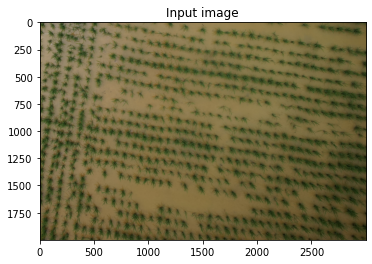

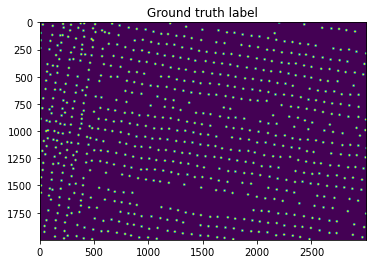

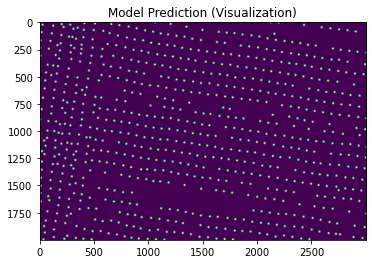

Class-averaging accuracy =  0.9217159936333932
Confusion matrix: 
[[5806881.  192364.]
 [     94.     661.]]


In [114]:
## Uncomment this to evaluate 1 training image
prediction, ground_truth = eval_one_training_image(model, img_name=_img_names[0], num_class=2, crop_size=(513, 513))

In [115]:
len(prediction)

749

In [116]:
len(ground_truth)

755

### 2. Evaluate whole training dataset

In [53]:
eval_whole_training_set(model, base_size=1024, crop_size=513)

Number of images in Train_Dev: 44
Class-averaging accuracy =  0.9624396848988539
Confusion matrix: 
[[11104286.   472208.]
 [     101.     2841.]]


### 3. Generate 1 testing result

In [117]:
def eval_one_testing_image(model, img_name='DSC080454', num_class=2, \
                            crop_size=(513,513), test_folder='test_public'):
    
    
    # Load image & ground truth label
    image = Image.open(os.path.join('../data/',test_folder,img_name+'.JPG')).convert('RGB')

    plt.figure()
    plt.imshow(image)
    plt.title('Input image')
    plt.show()

    print('Original image size = ',image.size)
    
    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225)
    
    # Crop image into crop_size
    input_images = []
    predictions = []
    for iw in range(image.size[0]//crop_size[0]+1):
        for ih in range(image.size[1]//crop_size[1]+1):
            x1, y1 = iw*crop_size[0], ih*crop_size[1]
            x2, y2 = min(x1+crop_size[0], image.size[0]), min(y1+crop_size[1], image.size[1])
            input_images.append({'image': image.crop((x1, y1, x2, y2)),
                                 'crop_origin': (x1, y1)})
    
    model.eval()
    # Evaluate each piece of image, and concatenate them afterall
    for input_image in input_images:
        img = np.array(input_image['image']).astype(np.float32)
        img /= 255.0
        img -= mean
        img /= std
        tensor_image = torch.unsqueeze(tf.ToTensor()(img).to(DEVICE), 0)
    
        # Feed into network
        output = model(tensor_image)
        pred = output.data.cpu().numpy()
        pred = np.argmax(pred, axis=1)        
        pred = np.transpose(np.nonzero(pred[0]))
        pred[:, [0,1]] = pred[:, [1,0]]
        pred += np.array(input_image['crop_origin'])
        
        predictions.append(pred)
        
    predictions = np.concatenate(predictions, axis=0)
    
    # Clustering for prediction
    clustering = DBSCAN(eps=15, min_samples=80)
    clustering.fit(predictions)
    
    _points = []
    for i in np.unique(clustering.labels_):
        if i == -1:
            continue
        _points.append(np.mean(predictions[clustering.labels_==i],axis=0).astype(np.int))
    _points = np.array(_points)
    
    _range = 10
    _dis = 10

    # Initial label array & array for visualizing label
    visualized_pred = np.zeros(image.size)
    for (x, y) in _points:
        for i in range(-_range, _range):
               for j in range(-_range, _range):
                    # Check if out-of-bound & make sure the point to be print is circle
                    if x+i >= visualized_pred.shape[0] or y+j >= visualized_pred.shape[1] \
                        or x+i<0 or y+j<0 or (i**2+j**2)**0.5 > _dis:
                        continue
                    visualized_pred[x+i, y+j] = 1.

    visualized_pred = np.transpose(visualized_pred)
    visualized_pred = Image.fromarray(np.uint8(visualized_pred*255))
    
    plt.figure()
    plt.imshow(visualized_pred)
    plt.title('Model Prediction (Visualization)')
    plt.show()
    
    return _points

In [118]:
test_folder = 'test_public' # can be 'test_public' or 'test_private'
# List all images
_img_names = sorted(os.listdir('../data/'+test_folder))
for i, _img in enumerate(_img_names):
    _img_names[i] = _img[:-4]
print('img_name in training dataset ; You can choose any of them')
print(_img_names)

img_name in training dataset ; You can choose any of them
['DSC080633', 'DSC080733', 'DSC080823', 'DSC080994', 'DSC081024', 'DSC081034', 'DSC081133', 'DSC081152', 'DSC081433', 'DSC081494', 'DSC081543', 'DSC081723', 'DSC082013', 'DSC082111', 'DSC082113', 'DSC082121', 'DSC082124', 'DSC082143', 'DSC082153', 'DSC082453', 'DSC082454', 'DSC082754', 'DSC082762', 'DSC082781', 'DSC082821', 'IMG_170406_035957_0043_RGB2', 'IMG_170406_040021_0063_RGB2', 'IMG_170406_040041_0079_RGB3', 'IMG_170406_040105_0099_RGB1', 'IMG_170406_040108_0102_RGB1', 'IMG_170406_040124_0115_RGB1', 'IMG_170406_040157_0143_RGB3', 'IMG_170406_040301_0196_RGB1', 'IMG_170406_040351_0238_RGB1', 'IMG_170406_040354_0240_RGB2', 'IMG_170406_040355_0241_RGB1', 'IMG_170406_040356_0242_RGB1', 'IMG_170406_040356_0242_RGB4', 'IMG_170406_040400_0245_RGB1', 'IMG_170406_040400_0245_RGB3', 'IMG_170406_040400_0245_RGB4', 'IMG_170406_040406_0250_RGB2', 'IMG_170406_040406_0250_RGB4', 'IMG_170406_040408_0252_RGB1', 'IMG_170406_040408_0252_RGB

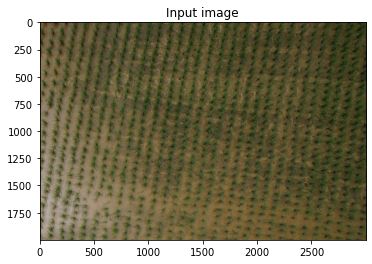

Original image size =  (3000, 2000)


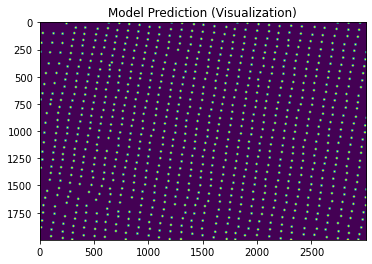

In [119]:
prediction = eval_one_testing_image(model, img_name=_img_names[0], num_class=2, \
                            crop_size=(513,513), test_folder=test_folder)

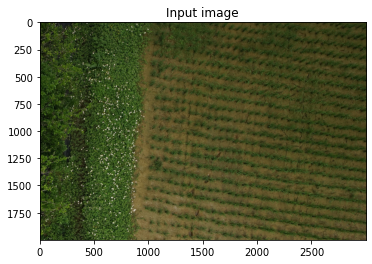

Original image size =  (3000, 2000)


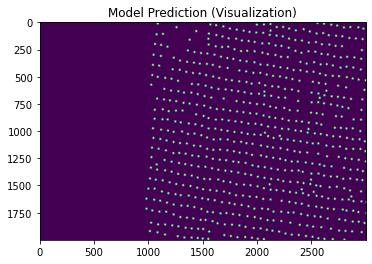

In [120]:
prediction = eval_one_testing_image(model, img_name=_img_names[2], num_class=2, \
                            crop_size=(513,513), test_folder=test_folder)